# BERT classifiers experiments

In [1]:
import numpy as np
import torch
import pandas as pd
import pickle
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

from huggingface_hub import login
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction, EarlyStoppingCallback
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import BatchAllTripletLoss
from datasets import Dataset

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from utils.utils import get_dataset_input, get_dataset_label, radar_plot

# check that a GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
# connect to Huggingface
HF_TOKEN = ""
login(token = HF_TOKEN, add_to_git_credential = True)

Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /home/clbleuze/.cache/huggingface/token
Login successful


## Inspect results

In [3]:
with open("results/BERT.pkl", "rb") as f:
    results = pickle.load(f)

with open("data/labels.json", "r") as f:
    LABELS = json.load(f)

### Strategy = threshold (0.5)

In [4]:
df = pd.read_csv("results/BERT-df.csv").rename(columns = {"Unnamed: 0": "model"})
df.sort_values(by = "weighted_avg", ascending = False)

,model,context-AIC,contribution-AIC,result,impact,directions,limitation,outline-AIC,nc,micro_avg,macro_avg,weighted_avg,samples_avg
8,scibert+prefix_cont_ll_SEP,0.929204,0.868852,0.862629,0.516129,0.820000,0.525253,0.880000,0.950666,0.894378,0.794092,0.892190,0.899910
5,deberta+prefix_cont_ll_SEP,0.916100,0.856423,0.870091,0.454545,0.813953,0.607843,0.904110,0.944488,0.893534,0.795944,0.890773,0.897664
7,scibert+prefix_cont_lr_SEP,0.924779,0.855586,0.867540,0.500000,0.804124,0.536082,0.849315,0.942474,0.890268,0.784988,0.886667,0.894991
1,roberta+prefix_cont_lr_SEP,0.889371,0.867403,0.864629,0.370370,0.784314,0.584906,0.873239,0.938547,0.882372,0.771597,0.881345,0.887264
4,deberta+prefix_cont_lr_SEP,0.904656,0.847716,0.846377,0.416667,0.808989,0.533333,0.838710,0.938095,0.877398,0.766818,0.875370,0.882727
2,roberta+prefix_cont_ll_SEP,0.894977,0.838046,0.853293,0.538462,0.764045,0.505051,0.852941,0.934066,0.874467,0.772610,0.871701,0.877246
6,scibert+prefix_SEP,0.857143,0.802168,0.799414,0.538462,0.731183,0.438095,0.805556,0.920660,0.841968,0.736585,0.839859,0.846473
0,roberta+prefix_SEP,0.841649,0.788406,0.802309,0.300000,0.696629,0.464646,0.818182,0.905929,0.832785,0.702219,0.828413,0.833109
3,deberta+prefix_SEP,0.820628,0.768844,0.816388,0.000000,0.722892,0.357895,0.848485,0.915094,0.831905,0.656278,0.824542,0.829268


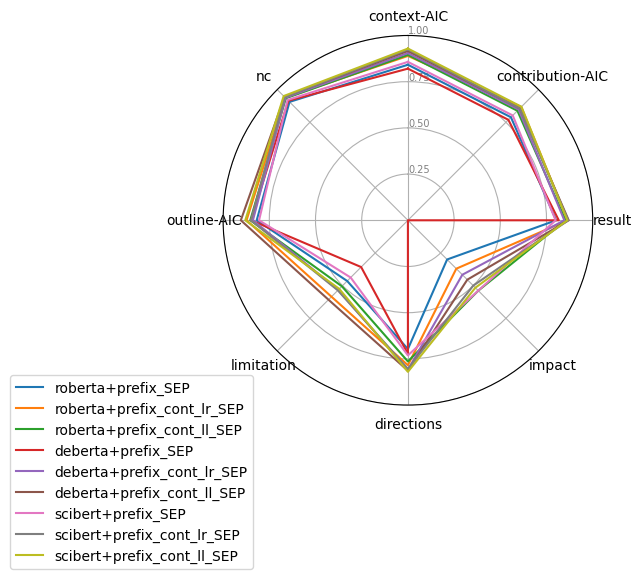

In [9]:
radar_plot(df[["model"] + LABELS])

### Strategy = constraints

In [6]:
# model2wf1 = {}
# for model_type in results.keys():
#     for input_type in results[model_type].keys():
#         model_name = f"{model_type}+{input_type}"
#         f1scores = {}
#         for i, l in enumerate(LABELS):
#             f1scores[LABELS[i]] = results[model_type][input_type]["classification_report_constraints"][l]["f1-score"]
#         for score in results[model_type][input_type]["classification_report_constraints"].keys():
#             if "avg" in score: 
#                 score_name = "_".join(score.split())
#                 f1scores[score_name] = results[model_type][input_type]["classification_report_constraints"][score]["f1-score"]
#         model2wf1[model_name] = f1scores

# df = pd.DataFrame(model2wf1).transpose()
# df.sort_values(by = "weighted_avg", ascending = False)
# df.to_csv("results/BERT-df-constraints.csv")

In [7]:
df_c = pd.read_csv("results/BERT-df-constraints.csv").rename(columns = {"Unnamed: 0": "model"})
df_c.sort_values(by = "weighted_avg", ascending = False)

,model,context-AIC,contribution-AIC,result,impact,directions,limitation,outline-AIC,nc,micro_avg,macro_avg,weighted_avg,samples_avg
8,scibert+prefix_cont_ll_SEP,0.931567,0.867209,0.861357,0.516129,0.820000,0.510204,0.880000,0.950743,0.893934,0.792151,0.891509,0.901707
5,deberta+prefix_cont_ll_SEP,0.909910,0.857143,0.873494,0.454545,0.827586,0.601942,0.904110,0.943838,0.893299,0.796571,0.890678,0.901033
7,scibert+prefix_cont_lr_SEP,0.927152,0.855586,0.866667,0.476190,0.804124,0.536082,0.849315,0.943485,0.890625,0.782325,0.886997,0.898360
1,roberta+prefix_cont_lr_SEP,0.883117,0.865014,0.864629,0.370370,0.776699,0.579439,0.873239,0.939394,0.880937,0.768988,0.880068,0.887713
4,deberta+prefix_cont_lr_SEP,0.904656,0.848485,0.846821,0.480000,0.813187,0.542056,0.838710,0.936508,0.877432,0.776303,0.875982,0.885872
2,roberta+prefix_cont_ll_SEP,0.895455,0.836735,0.850746,0.562500,0.769231,0.505051,0.852941,0.934902,0.873818,0.775945,0.871788,0.881289
6,scibert+prefix_SEP,0.860310,0.805405,0.802941,0.571429,0.736842,0.438095,0.821918,0.920784,0.844329,0.744716,0.842415,0.852314
0,roberta+prefix_SEP,0.840085,0.790831,0.801153,0.300000,0.688889,0.455446,0.794118,0.906225,0.831373,0.697093,0.827206,0.838387
3,deberta+prefix_SEP,0.813333,0.762376,0.819277,0.000000,0.733333,0.387755,0.848485,0.915625,0.831431,0.660023,0.825021,0.837579


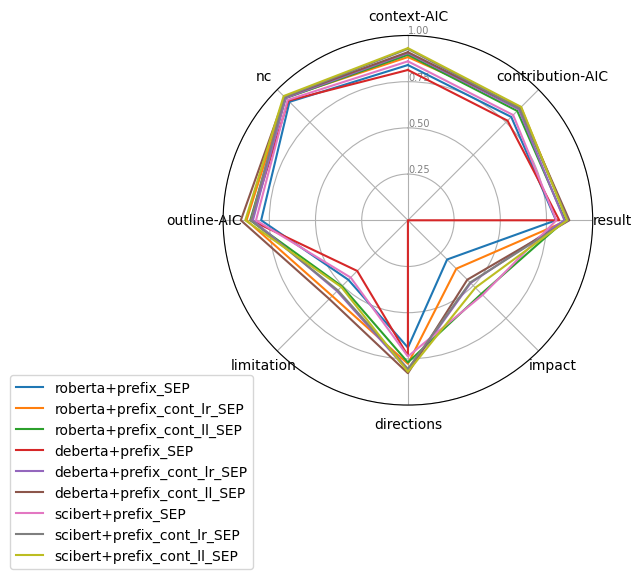

In [10]:
radar_plot(df_c[["model"] + LABELS], save_path = "results/BERT-constraints-radar.png")

## Data preparation

### Load train, eval and test splits

In [2]:
with open("data/train_final.pkl", "rb") as f:
    train_ds = pickle.load(f)

with open("data/eval_final.pkl", "rb") as f:
    eval_ds = pickle.load(f)

with open("data/test_final.pkl", "rb") as f:
    test_ds = pickle.load(f)

In [3]:
train_ds

Dataset({
    features: ['text', 'section', 'li', 'label', '-2', '-1', '+1'],
    num_rows: 11830
})

### Test different input / label formats

In [4]:
input_data = {"prefix_SEP": {},
              "prefix_cont_lr_SEP": {},
              "prefix_cont_ll_SEP": {},
             }
PATH_TO_DATA = "data/processed-annotations-11-06.csv"

for input_type in input_data.keys():
    for split, ds in zip(["train", "eval", "test"], [train_ds, eval_ds, test_ds]):
        input_data[input_type][split] = get_dataset_input(ds, PATH_TO_DATA, type = input_type)

In [8]:
# we just use the default multi-label config (encoded as 1-hot vectors)
y_train = get_dataset_label(train_ds)
y_eval = get_dataset_label(eval_ds)
y_test = get_dataset_label(test_ds)

labels = {"train": y_train, "eval": y_eval, "test": y_test}

## Vectorization

### Tokenization

In [9]:
# define tokenization function
def tokenize_function(tokenizer):
    def tokenize(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
    return tokenize

In [10]:
CHECKPOINTS = {
    "roberta": "FacebookAI/roberta-base",
    "deberta": "microsoft/deberta-v3-base",
    "scibert": "allenai/scibert_scivocab_uncased",
}

In [11]:
input_data_per_model_family = {}

for model_family in CHECKPOINTS.keys():
    # load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINTS[model_family])
    print(len(tokenizer.vocab))
    #add new special token separator for section
    special_tokens_dict = {'additional_special_tokens': ['[SEC]']}
    num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
    print(len(tokenizer.vocab))
    
    input_data_per_model_family[model_family] = {}
    
    # apply on the data
    for input_type in input_data.keys():
        input_data_per_model_family[model_family][input_type] = {}
        for split in input_data[input_type].keys():
            dataset = Dataset.from_dict({"text": input_data[input_type][split], "label": labels[split]})
            input_data_per_model_family[model_family][input_type][split] = dataset.map(tokenize_function(tokenizer), batched = True)

50265
50266


Map:   0%|          | 0/11830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1478 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/11830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1478 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/11830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1478 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

/home/clbleuze/myenv/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


128001
128002


Map:   0%|          | 0/11830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1478 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/11830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1478 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/11830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1478 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

/home/clbleuze/myenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


31090
31091


Map:   0%|          | 0/11830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1478 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/11830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1478 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/11830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1478 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

In [12]:
input_data_per_model_family["scibert"]["prefix_cont_ll_SEP"]["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 11830
})

## Models

### Training

In [13]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_samples_average = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
    f1_weighted_average = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1_weighted': f1_weighted_average,
               'f1_samples': f1_samples_average,
               'f1_macro': f1_macro_average,
               'f1_micro' : f1_micro_average,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [12]:
with open("results/BERT.pkl", "rb") as f:
    results = pickle.load(f)

results["roberta"].keys()

dict_keys(['prefix_SEP', 'prefix_cont_lr_SEP', 'prefix_cont_ll_SEP'])

In [13]:
with open("results/BERT.pkl", "rb") as f:
    results = pickle.load(f)

for model_family in input_data_per_model_family.keys():
    if model_family not in results.keys():
        results[model_family] = {}
        
    for input_type in  input_data_per_model_family[model_family].keys():

        os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

        # skip models already trained (until the end)
        if input_type in results[model_family].keys():
            continue

        # load the model to be fine-tuned
        model_name = f"{model_family}_{input_type}"
        model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINTS[model_family],
                                                          num_labels = len(LABELS),
                                                          problem_type = "multi_label_classification")

        # load the tokenizer
        tokenizer = AutoTokenizer.from_pretrained(CHECKPOINTS[model_family])
        # add new special token separator for section
        special_tokens_dict = {'additional_special_tokens': ['[SEC]']}
        num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
        # resize model embeddings
        model.resize_token_embeddings(len(tokenizer))

        # datasets
        train_ds = input_data_per_model_family[model_family][input_type]["train"]
        eval_ds = input_data_per_model_family[model_family][input_type]["eval"]
        test_ds = input_data_per_model_family[model_family][input_type]["test"]

        # safety check: does model inference work correctly ?
        print(f"Successfully loaded model {model_name} !\n Small example :\n")
        ex_sent = "We believe that this will be useful for other languages too."
        print(f"Example sentence: {ex_sent}\n")
        inputs = tokenizer(ex_sent, return_tensors="pt")
        logits = model(**inputs).logits
        probas = torch.nn.Sigmoid()(logits.squeeze().cuda())
        print(probas)

        # define the training arguments
        training_args = TrainingArguments(
            output_dir=f"models/NEW/{model_name}",
            push_to_hub = True,
            num_train_epochs= 15,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            weight_decay=0.1,
            learning_rate = 1e-5,
            logging_dir="./logs",
            eval_strategy="steps",
            eval_steps = 500,
            save_strategy = "steps",
            save_steps = 500,
            logging_steps = 500,
            save_total_limit = 2,
            load_best_model_at_end = True,
            metric_for_best_model = "f1_weighted",
        )

        # define the Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_ds,
            eval_dataset=eval_ds,
            compute_metrics = compute_metrics,
            callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)] # stop when the performance degrades for 3 consecutive eval steps
        )

        # let the model run on the GPU
        model = model.to(device)

        # train
        try:
            trainer.train(resume_from_checkpoint = True) # in case of an interrupted training
        except:
            trainer.train()
            
        trainer.evaluate()

        # push to hub
        trainer.push_to_hub()

        # re-run the initial example
        ex_sent = "We believe that this will be useful for other languages too."
        print(f"Example sentence: {ex_sent}\n")
        inputs = tokenizer(ex_sent, return_tensors="pt").to(device)
        logits = model(**inputs).logits
        probas = torch.nn.Sigmoid()(torch.tensor(logits))
        print(probas)

        # on the test set
        logits = trainer.predict(test_ds).predictions
        sigmoid = torch.nn.Sigmoid()
        probas = sigmoid(torch.tensor(logits))
        predictions = np.zeros(probas.shape)
        predictions[np.where(probas >= 0.50)] = 1
        gold = test_ds["label"]
        cr = classification_report(gold, predictions, target_names = LABELS, zero_division = 0, output_dict = True)

        # store results
        results[model_family][input_type] = {
            "log_history" : trainer.state.log_history,
            "classification_report": cr,
        }

        with open("results/BERT.pkl", "wb") as f:
            pickle.dump(results, f)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully loaded model scibert_prefix_SEP !
 Small example :

Example sentence: We believe that this will be useful for other languages too.

tensor([0.5242, 0.4880, 0.5638, 0.5282, 0.5523, 0.4215, 0.5311, 0.5195],
       device='cuda:0', grad_fn=<SigmoidBackward0>)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,F1 Weighted,F1 Samples,F1 Macro,F1 Micro,Accuracy
3000,0.104000,0.110228,0.850850,0.855210,0.702564,0.855826,0.820704
3500,0.074000,0.109233,0.853929,0.860397,0.708115,0.859591,0.826793
4000,0.077600,0.108736,0.857324,0.864456,0.713428,0.865187,0.837618
4500,0.073800,0.113642,0.857293,0.861863,0.735485,0.863471,0.832206
5000,0.053300,0.109963,0.862088,0.867591,0.756279,0.866514,0.831529
5500,0.053400,0.118143,0.853066,0.858593,0.702774,0.858928,0.826793
6000,0.054900,0.108464,0.876321,0.878101,0.800311,0.877044,0.847767
6500,0.035600,0.116928,0.868392,0.873478,0.754532,0.871626,0.845737
7000,0.038000,0.121809,0.865817,0.871651,0.745787,0.868232,0.837618
7500,0.034900,0.122880,0.869692,0.876364,0.751854,0.872180,0.842355


Example sentence: We believe that this will be useful for other languages too.

tensor([[0.0290, 0.0537, 0.0277, 0.5621, 0.4030, 0.0177, 0.0096, 0.0297]],
       device='cuda:0')


/tmp/ipykernel_1006793/2758355497.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probas = torch.nn.Sigmoid()(torch.tensor(logits))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/clbleuze/myenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Successfully loaded model scibert_prefix_cont_lr_SEP !
 Small example :

Example sentence: We believe that this will be useful for other languages too.

tensor([0.5176, 0.7337, 0.3848, 0.5391, 0.5237, 0.5016, 0.3664, 0.4494],
       device='cuda:0', grad_fn=<SigmoidBackward0>)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,F1 Weighted,F1 Samples,F1 Macro,F1 Micro,Accuracy
500,0.230700,0.172839,0.744801,0.716734,0.587936,0.760862,0.694858
1000,0.149300,0.127108,0.810612,0.805593,0.621557,0.826384,0.785521
1500,0.128800,0.115765,0.837972,0.842467,0.684316,0.848161,0.818674
2000,0.101000,0.101084,0.862605,0.860735,0.714346,0.868984,0.836942
2500,0.095500,0.105827,0.857346,0.862427,0.710035,0.865135,0.834235
3000,0.091300,0.095622,0.873478,0.880131,0.722409,0.880424,0.850474
3500,0.064700,0.106637,0.861347,0.870771,0.701193,0.868334,0.843031
4000,0.066000,0.093812,0.879591,0.887686,0.738148,0.885959,0.859946
4500,0.061700,0.084378,0.892162,0.899301,0.755917,0.897487,0.874154
5000,0.042200,0.092113,0.895556,0.903811,0.772889,0.900230,0.877537


Example sentence: We believe that this will be useful for other languages too.

tensor([[0.0527, 0.0239, 0.0703, 0.2893, 0.6643, 0.0146, 0.0130, 0.0138]],
       device='cuda:0')


/tmp/ipykernel_1006793/2758355497.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probas = torch.nn.Sigmoid()(torch.tensor(logits))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/clbleuze/myenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Successfully loaded model scibert_prefix_cont_ll_SEP !
 Small example :

Example sentence: We believe that this will be useful for other languages too.

tensor([0.5677, 0.4933, 0.5262, 0.5689, 0.5118, 0.4977, 0.5093, 0.4616],
       device='cuda:0', grad_fn=<SigmoidBackward0>)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,F1 Weighted,F1 Samples,F1 Macro,F1 Micro,Accuracy
500,0.221300,0.139167,0.815081,0.822282,0.608078,0.835537,0.801759
1000,0.137700,0.112922,0.852271,0.858367,0.688929,0.864520,0.834235
1500,0.121400,0.110337,0.850445,0.855210,0.695481,0.861333,0.830176
2000,0.092100,0.096091,0.865625,0.865471,0.711148,0.873995,0.838972
2500,0.086300,0.089999,0.878894,0.881033,0.728130,0.884692,0.854533
3000,0.082500,0.095915,0.876394,0.884416,0.732309,0.882586,0.853180
3500,0.056700,0.085617,0.887935,0.895129,0.745418,0.892237,0.863329
4000,0.061000,0.095192,0.880192,0.882724,0.739674,0.885648,0.858593
4500,0.053200,0.083929,0.897945,0.905841,0.763933,0.903098,0.877537
5000,0.036100,0.083146,0.900730,0.911254,0.779051,0.904467,0.876861


Example sentence: We believe that this will be useful for other languages too.

tensor([[0.0439, 0.0110, 0.0207, 0.5026, 0.4139, 0.0075, 0.0104, 0.0146]],
       device='cuda:0')


/tmp/ipykernel_1006793/2758355497.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probas = torch.nn.Sigmoid()(torch.tensor(logits))


In [14]:
import torch
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())


12.1
8902
True


## Inference: store predictions

In [24]:
# inf = {}
# hf_prefix = "ClementineBleuze"

# for model_family in results.keys():
#     inf[model_family] = {}
    
#     for input_type in results[model_family].keys():
        
#         # load the model to be fine-tuned
#         model_name = f"{hf_prefix}/{model_family}_{input_type}"
#         model = AutoModelForSequenceClassification.from_pretrained(model_name,
#                                                           num_labels = len(LABELS),
#                                                           problem_type = "multi_label_classification")

#         # load the tokenizer
#         tokenizer = AutoTokenizer.from_pretrained(CHECKPOINTS[model_family])
#         # add new special token separator for section
#         special_tokens_dict = {'additional_special_tokens': ['[SEC]']}
#         num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
#         # resize model embeddings
#         model.resize_token_embeddings(len(tokenizer))

#         # load test data
#         test_ds = input_data_per_model_family[model_family][input_type]["test"]

#         # create a trainer 
#         args = TrainingArguments(output_dir = "results", per_device_eval_batch_size = 8)
#         trainer = Trainer(model = model, args = args)

#         # on the test set
#         logits = trainer.predict(test_ds).predictions
#         sigmoid = torch.nn.Sigmoid()
#         probas = sigmoid(torch.tensor(logits))
#         predictions = np.zeros(probas.shape)
#         predictions[np.where(probas >= 0.50)] = 1
#         gold = test_ds["label"]
#         cr = classification_report(gold, predictions, target_names = LABELS, zero_division = 0, output_dict = True)

#         # store results
#         inf[model_family][input_type] = {
#             "classification_report": cr,
#             "logits": logits,
#             "predictions": predictions,
#         }
        
    

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/737M [00:00<?, ?B/s]

/home/clbleuze/myenv/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/737M [00:00<?, ?B/s]

/home/clbleuze/myenv/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/737M [00:00<?, ?B/s]

/home/clbleuze/myenv/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/home/clbleuze/myenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/home/clbleuze/myenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/home/clbleuze/myenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
# model2wf1 = {}
# for model_type in inf.keys():
#     for input_type in inf[model_type].keys():
#         model_name = f"{model_type}+{input_type}"
#         f1scores = {}
#         for i, l in enumerate(LABELS):
#             f1scores[LABELS[i]] = inf[model_type][input_type]["classification_report"][l]["f1-score"]
#         for score in inf[model_type][input_type]["classification_report"].keys():
#             if "avg" in score: 
#                 score_name = "_".join(score.split())
#                 f1scores[score_name] = inf[model_type][input_type]["classification_report"][score]["f1-score"]
#         model2wf1[model_name] = f1scores

# df = pd.DataFrame(model2wf1).transpose()
# df.sort_values(by = "weighted_avg", ascending = False)

,context-AIC,contribution-AIC,result,impact,directions,limitation,outline-AIC,nc,micro_avg,macro_avg,weighted_avg,samples_avg
scibert+prefix_cont_ll_SEP,0.929204,0.868852,0.862629,0.516129,0.820000,0.525253,0.880000,0.950666,0.894378,0.794092,0.892190,0.899910
deberta+prefix_cont_ll_SEP,0.916100,0.856423,0.870091,0.454545,0.813953,0.607843,0.904110,0.944488,0.893534,0.795944,0.890773,0.897664
scibert+prefix_cont_lr_SEP,0.924779,0.855586,0.867540,0.500000,0.804124,0.536082,0.849315,0.942474,0.890268,0.784988,0.886667,0.894991
roberta+prefix_cont_lr_SEP,0.889371,0.867403,0.864629,0.370370,0.784314,0.584906,0.873239,0.938547,0.882372,0.771597,0.881345,0.887264
deberta+prefix_cont_lr_SEP,0.904656,0.847716,0.846377,0.416667,0.808989,0.533333,0.838710,0.938095,0.877398,0.766818,0.875370,0.882727
roberta+prefix_cont_ll_SEP,0.894977,0.838046,0.853293,0.538462,0.764045,0.505051,0.852941,0.934066,0.874467,0.772610,0.871701,0.877246
scibert+prefix_SEP,0.857143,0.802168,0.799414,0.538462,0.731183,0.438095,0.805556,0.920660,0.841968,0.736585,0.839859,0.846473
roberta+prefix_SEP,0.841649,0.788406,0.802309,0.300000,0.696629,0.464646,0.818182,0.905929,0.832785,0.702219,0.828413,0.833109
deberta+prefix_SEP,0.820628,0.768844,0.816388,0.000000,0.722892,0.357895,0.848485,0.915094,0.831905,0.656278,0.824542,0.829268


In [32]:
# for model_family in inf.keys():
#     for input_type in inf[model_family].keys():
#         results[model_family][input_type]["classification_report_with_preds"] = inf[model_family][input_type]["classification_report"]
#         results[model_family][input_type]["logits"] = inf[model_family][input_type]["logits"]
#         results[model_family][input_type]["predictions"] = {
#             "t=0.5" : inf[model_family][input_type]["predictions"],
#         }

In [38]:
# with open("results/BERT.pkl", "wb") as f:
#     pickle.dump(results, f)

In [122]:
def get_predictions_from_logits(logits, strategy = "", threshold = 0.5, use_sigmoid = True):

    # if needed, start by applying the sigmoid function to logits, to have values between 0 and 1
    if use_sigmoid:
        sigmoid = torch.nn.Sigmoid()
        probas = sigmoid(torch.tensor(logits))
    else:
        probas = torch.tensor(logits)

    if strategy == "argmax":
        predictions = np.zeros(probas.shape)
        for i, row in enumerate(probas):
            max_ = max(row).item()
            predictions[i][np.where(row == max_)] = 1

    elif strategy == "constraints":
        predictions = np.zeros(probas.shape)
        for i, row in enumerate(probas):
            argmax = np.argmax(row)
            predictions[i][argmax] = 1

            if argmax != 7:
                other_labels = [j for j in range(8) if i!= argmax and row[j] >= threshold and row[j] > row[7]]
                predictions[i][other_labels] = 1

    else:
        predictions = np.zeros(probas.shape)
        predictions[np.where(probas >= threshold)] = 1

    return predictions
    

In [123]:
input_data_per_model_family["roberta"]["prefix_cont_ll_SEP"]["test"]["text"][15:20]

['Analysis[SEC]Furthermore, tasks demanding exact equality (task sent01) prove more challenging than those requiring a range (task para03), and are considerably more difficult than tasks specifying just an upper or lower bound (tasks word01, sent03, para04). [SEP]Increased difficulty with logical composition.[SEP]The incorporation of logical compositions into constraints considerably increases their difficulty.',
 'Conclusion and Future Work[SEC]Furthermore, the joint parser achieved the best performance, an improvement of over 2.2 LAS points from the previous state-of-the-art.[SEP]We have also seen that the joint parser yields state-of-the-art in textual entailment and unbounded dependency recovery tasks, and raised the possibility that TAG can provide useful structural analysis of sentences for other NLP tasks.[SEP]We will explore more applications of our TAG parsers in future work.',
 'Generation[SEC]The statistical model is therefore still applicable to the derived generation gramm

In [124]:
logits = results["deberta"]["prefix_cont_ll_SEP"]["logits"]
for row in logits[15:20]:
    print(row)

[-8.700507  -6.7617826  4.97776   -8.452294  -7.900831  -3.3996882
 -8.344694  -5.757049 ]
[-4.877341  -4.912148  -4.720849  -2.6606655  4.2404156 -3.9510045
 -5.991606  -5.9420023]
[-8.699544  -7.1979084  1.950918  -9.026472  -8.807053  -2.548445
 -9.6226015 -2.958127 ]
[-7.358006  -7.3440814 -6.358609  -9.528758  -8.910784  -8.505489
 -9.0073595  6.1526084]
[ -7.478571  -7.80916   -5.271467 -10.225271  -9.844537  -9.084631
  -9.359738   5.223785]


In [125]:
preds = get_predictions_from_logits(logits, strategy = "constraints", use_sigmoid = True)
for row in preds[15:20]:
    print(row)

[0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 1.]


In [126]:
for model_family in results.keys():
    for input_type in results[model_family].keys():
        logits = results[model_family][input_type]["logits"]
        preds_constraints = get_predictions_from_logits(logits, strategy = "constraints", use_sigmoid = True)

        #load test data
        test_ds = input_data_per_model_family[model_family][input_type]["test"]
        gold = test_ds["label"]
        
        cr_constraints = classification_report(gold, preds_constraints, target_names = LABELS, zero_division = 0, output_dict = True)
        results[model_family][input_type]["predictions_constraints"] = preds_constraints
        results[model_family][input_type]["classification_report_constraints"] = cr_constraints

In [130]:
with open("results/BERT.pkl", "wb") as f:
    pickle.dump(results,f)